# Test Data Prep
This page is meant to prepare test fixtures for use in hydrofunctions.

**Table of Contents:**
- Create sample NWIS responses to requests.
- Check values of test fixtures.
- Check individual values within the mult_flags fixture
- Check that missing index values are filled.
- Check that data requests with different frequencies of observations raise a warning.

In [1]:
import hydrofunctions as hf
print("Hydrofunctions version: ", hf.__version__)
import numpy as np
print("Numpy version: ", np.__version__)
import pandas as pd
print("Pandas version: ", pd.__version__)
import requests
print("Requests version: ", requests.__version__)
import matplotlib as plt
%matplotlib inline

Hydrofunctions version:  0.1.7
Numpy version:  1.16.1
Pandas version:  0.24.1
Requests version:  2.21.0


## Create sample NWIS responses to requests.

The cells below will generate the output a user would expect to get from successful requests by hf.NWIS.json().
In other words, these are not the raw JSON returned by the NWIS, but rather
the output from calling the .json() method on a Requests object. It actually
isn't json, but rather a Python dict. You can tell because the true and false 
in the original json have been coverted to True and False for Python.

Each of the fixtures will represent the response to a different type of request to the NWIS. These will be used
to test whether hydrofunctions is parsing the JSON correctly. Note that I need to call these directly from the NWIS
using Requests, not hydrofunctions!

**NOTE:** within the response from NWIS, there is a field called 'queryURL', which contains the query used to generate this response... except with one tiny modification. The 'queryURL' doesn't contain the '?' neccessary between the static part of the URL and the requested parameters. Is this a bug?

| Request Name     | NWIS request URL     |  Description                 |
|------------------|----------------------|------------------------------|
| JSON15min2month  | http://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=03213700&parameterCd=00060&startDT=2016-09-01&endDT=2017-11-01             | A fairly long request for discharge from one site.  |
|two_sites_two_params_iv | http://waterservices.usgs.gov/nwis/iv/?format=json&sites=01541000,01541200&siteStatus=all  | Returns stage & discharge for two sites, along with qualifier flags. |
| nothing_avail  | http://waterservices.usgs.gov/nwis/iv/?format=json&indent=on&stateCd=al&parameterCd=00001&siteStatus=all   | This is basically an empty dataset. NWIS returns this in response to filters that filter too much stuff, requests for parameters that don't exist, or don't exist at this station... |
| mult_flags  | http://waterservices.usgs.gov/nwis/iv/?format=json&sites=01542500&startDT=2019-01-24&endDT=2019-01-28&parameterCd=00060   | NWIS returns data for discharge at one site, but with 3 _qualifier flags: 'e':estimated, 'P': provisional data, 'Ice'. |
| diff_freq  | https://waterservices.usgs.gov/nwis/iv/?format=json&sites=01570500,01541000&startDT=2018-06-01&endDT=2018-06-01  | The 01541000 site collects every 15 minutes; the 01570500 collects every 30 minutes. The 01570500 site also collects other parameters like precipitation; these have no data for these dates, but NWIS reports them as if there is a data series, but it just delivers an empty series. If you request just the parameter with no data, the NWIS doesn't return any series, so this requires a test during parsing. |

In [2]:
header = {'Accept-encoding': 'gzip','max-age': '120'}
JSON15min2day_req =           requests.get("https://waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=03213700&parameterCd=00060&startDT=2016-09-01&endDT=2016-09-02", headers=header)
two_sites_two_params_iv_req = requests.get("https://waterservices.usgs.gov/nwis/iv/?format=json&sites=01541000,01541200&period=P1D", headers=header)
nothing_avail_req =           requests.get("https://waterservices.usgs.gov/nwis/iv/?format=json&indent=on&stateCd=al&parameterCd=00001", headers=header)
mult_flags_req =              requests.get("https://waterservices.usgs.gov/nwis/iv/?format=json&sites=01542500&startDT=2019-01-24&endDT=2019-01-28&parameterCd=00060", headers=header)
diff_freq =                   requests.get("https://waterservices.usgs.gov/nwis/iv/?format=json&sites=01570500,01541000&startDT=2018-06-01&endDT=2018-06-01", headers=header)


In [3]:
JSON15min2day_req.json()

{'name': 'ns1:timeSeriesResponseType',
 'declaredType': 'org.cuahsi.waterml.TimeSeriesResponseType',
 'scope': 'javax.xml.bind.JAXBElement$GlobalScope',
 'value': {'queryInfo': {'queryURL': 'http://nwis.waterservices.usgs.gov/nwis/iv/format=json%2C1.1&sites=03213700&parameterCd=00060&startDT=2016-09-01&endDT=2016-09-02',
   'criteria': {'locationParam': '[ALL:03213700]',
    'variableParam': '[00060]',
    'timeParam': {'beginDateTime': '2016-09-01T00:00:00.000',
     'endDateTime': '2016-09-02T23:59:59.000'},
    'parameter': []},
   'note': [{'value': '[ALL:03213700]', 'title': 'filter:sites'},
    {'value': '[mode=RANGE, modifiedSince=null] interval={INTERVAL[2016-09-01T00:00:00.000-04:00/2016-09-02T23:59:59.000Z]}',
     'title': 'filter:timeRange'},
    {'value': 'methodIds=[ALL]', 'title': 'filter:methodId'},
    {'value': '2019-02-21T04:13:40.125Z', 'title': 'requestDT'},
    {'value': '1178ddc0-358f-11e9-a754-3440b59d3362', 'title': 'requestId'},
    {'value': 'Provisional data

In [4]:
two_sites_two_params_iv_req.json()

{'name': 'ns1:timeSeriesResponseType',
 'declaredType': 'org.cuahsi.waterml.TimeSeriesResponseType',
 'scope': 'javax.xml.bind.JAXBElement$GlobalScope',
 'value': {'queryInfo': {'queryURL': 'http://waterservices.usgs.gov/nwis/iv/format=json&sites=01541000,01541200&period=P1D',
   'criteria': {'locationParam': '[ALL:01541000, ALL:01541200]',
    'variableParam': 'ALL',
    'parameter': []},
   'note': [{'value': '[ALL:01541000, ALL:01541200]', 'title': 'filter:sites'},
    {'value': '[mode=PERIOD, period=P1D, modifiedSince=null]',
     'title': 'filter:timeRange'},
    {'value': 'methodIds=[ALL]', 'title': 'filter:methodId'},
    {'value': '2019-02-21T04:13:40.506Z', 'title': 'requestDT'},
    {'value': '11b30090-358f-11e9-9bb5-6cae8b663fb6', 'title': 'requestId'},
    {'value': 'Provisional data are subject to revision. Go to http://waterdata.usgs.gov/nwis/help/?provisional for more information.',
     'title': 'disclaimer'},
    {'value': 'vaas01', 'title': 'server'}]},
  'timeSeries'

In [5]:
nothing_avail_req.json()

{'name': 'ns1:timeSeriesResponseType',
 'declaredType': 'org.cuahsi.waterml.TimeSeriesResponseType',
 'scope': 'javax.xml.bind.JAXBElement$GlobalScope',
 'value': {'queryInfo': {'queryURL': 'http://waterservices.usgs.gov/nwis/iv/format=json&indent=on&stateCd=al&parameterCd=00001',
   'criteria': {'locationParam': '[]',
    'variableParam': '[00001]',
    'parameter': []},
   'note': [{'value': '[al]', 'title': 'filter:stateCd'},
    {'value': '[mode=LATEST, modifiedSince=null]',
     'title': 'filter:timeRange'},
    {'value': 'methodIds=[ALL]', 'title': 'filter:methodId'},
    {'value': '2019-02-21T04:13:40.952Z', 'title': 'requestDT'},
    {'value': '11e3ad80-358f-11e9-9bb5-6cae8b663fb6', 'title': 'requestId'},
    {'value': 'Provisional data are subject to revision. Go to http://waterdata.usgs.gov/nwis/help/?provisional for more information.',
     'title': 'disclaimer'},
    {'value': 'vaas01', 'title': 'server'}]},
  'timeSeries': []},
 'nil': False,
 'globalScope': True,
 'typeSu

In [6]:
mult_flags_req.json()

{'name': 'ns1:timeSeriesResponseType',
 'declaredType': 'org.cuahsi.waterml.TimeSeriesResponseType',
 'scope': 'javax.xml.bind.JAXBElement$GlobalScope',
 'value': {'queryInfo': {'queryURL': 'http://waterservices.usgs.gov/nwis/iv/format=json&sites=01542500&startDT=2019-01-24&endDT=2019-01-28&parameterCd=00060',
   'criteria': {'locationParam': '[ALL:01542500]',
    'variableParam': '[00060]',
    'timeParam': {'beginDateTime': '2019-01-24T00:00:00.000',
     'endDateTime': '2019-01-28T23:59:59.000'},
    'parameter': []},
   'note': [{'value': '[ALL:01542500]', 'title': 'filter:sites'},
    {'value': '[mode=RANGE, modifiedSince=null] interval={INTERVAL[2019-01-24T00:00:00.000-05:00/2019-01-28T23:59:59.000Z]}',
     'title': 'filter:timeRange'},
    {'value': 'methodIds=[ALL]', 'title': 'filter:methodId'},
    {'value': '2019-02-21T04:13:41.252Z', 'title': 'requestDT'},
    {'value': '1224d530-358f-11e9-9bb5-6cae8b663fb6', 'title': 'requestId'},
    {'value': 'Provisional data are subjec

In [7]:
diff_freq.json()

{'name': 'ns1:timeSeriesResponseType',
 'declaredType': 'org.cuahsi.waterml.TimeSeriesResponseType',
 'scope': 'javax.xml.bind.JAXBElement$GlobalScope',
 'value': {'queryInfo': {'queryURL': 'http://nwis.waterservices.usgs.gov/nwis/iv/format=json&sites=01570500,01541000&startDT=2018-06-01&endDT=2018-06-01',
   'criteria': {'locationParam': '[ALL:01570500, ALL:01541000]',
    'variableParam': 'ALL',
    'timeParam': {'beginDateTime': '2018-06-01T00:00:00.000',
     'endDateTime': '2018-06-01T23:59:59.000'},
    'parameter': []},
   'note': [{'value': '[ALL:01570500, ALL:01541000]', 'title': 'filter:sites'},
    {'value': '[mode=RANGE, modifiedSince=null] interval={INTERVAL[2018-06-01T00:00:00.000-04:00/2018-06-01T23:59:59.000Z]}',
     'title': 'filter:timeRange'},
    {'value': 'methodIds=[ALL]', 'title': 'filter:methodId'},
    {'value': '2019-02-21T04:13:41.942Z', 'title': 'requestDT'},
    {'value': '128e1e50-358f-11e9-a754-3440b59d3362', 'title': 'requestId'},
    {'value': 'Provisi

## Check values of test fixtures
**Several properties of the test dataframes can be checked, including: **
- .shape : the number of columns and rows. (returns a tuple)
- .columns.values : the names of the columns (returns a list)
- .index.is_unique : are there any repeated values in the time index values? (True|False)
- .index.is_monotonic : index values increase in order. (True|False)


In [8]:
# Import the 'JSON' dicts from our test_data module.
from tests.test_data import JSON15min2day, two_sites_two_params_iv, nothing_avail, mult_flags, diff_freq

In [9]:
two =  hf.extract_nwis_df(two_sites_two_params_iv)
json = hf.extract_nwis_df(JSON15min2day)
mult = hf.extract_nwis_df(mult_flags)
diff = hf.extract_nwis_df(diff_freq)

c:\users\marty\google drive\pydev\src\hydrofunctions\hydrofunctions\hydrofunctions.py:364: HydroUserWarning: One or more datasets in this request is going to be 'upsampled' to <15 * Minutes> because the data were collected at a lower frequency of <30 * Minutes>
  exceptions.HydroUserWarning)


In [10]:
diff_freq['value']['timeSeries'][3]

{'sourceInfo': {'siteName': 'Susquehanna River at Harrisburg, PA',
  'siteCode': [{'value': '01570500', 'network': 'NWIS', 'agencyCode': 'USGS'}],
  'timeZoneInfo': {'defaultTimeZone': {'zoneOffset': '-05:00',
    'zoneAbbreviation': 'EST'},
   'daylightSavingsTimeZone': {'zoneOffset': '-04:00',
    'zoneAbbreviation': 'EDT'},
   'siteUsesDaylightSavingsTime': True},
  'geoLocation': {'geogLocation': {'srs': 'EPSG:4326',
    'latitude': 40.25481164,
    'longitude': -76.8860846},
   'localSiteXY': []},
  'note': [],
  'siteType': [],
  'siteProperty': [{'value': 'ST', 'name': 'siteTypeCd'},
   {'value': '02050305', 'name': 'hucCd'},
   {'value': '42', 'name': 'stateCd'},
   {'value': '42043', 'name': 'countyCd'}]},
 'variable': {'variableCode': [{'value': '00045',
    'network': 'NWIS',
    'vocabulary': 'NWIS:UnitValues',
    'variableID': 45807140,
    'default': True}],
  'variableName': 'Precipitation, total, in',
  'variableDescription': 'Precipitation, total, inches',
  'valueTyp

In [11]:
diff_freq['value']['timeSeries'][3]['values'][0]['value']

[]

In [12]:
shapes = {'two':two.shape, 'json':json.shape, 'mult':mult.shape, 'diff':diff.shape}
shapes

{'two': (93, 8), 'json': (192, 2), 'mult': (438, 2), 'diff': (96, 8)}

In [13]:
mult.columns.values

array(['USGS:01542500:00060:00000_qualifiers',
       'USGS:01542500:00060:00000'], dtype=object)

In [14]:
json.index.is_unique

True

In [15]:
two.index.is_monotonic

True

## Check individual values within the mult_flags fixture
The mult_flags dataframe should have all three flags, with multiple flags in some locations.
- 2019-01-24T10:30 has P & e
- 2019-01-28T16:00 has P & Ice; value is -999999; should be converted to np.nan


In [16]:
mult.loc['2019-01-24T10:30', 'USGS:01542500:00060:00000_qualifiers']

'P,e'

In [17]:
mult.loc['2019-01-28T16:00:00.000-05:00', 'USGS:01542500:00060:00000_qualifiers']

'P,Ice'

In [18]:
type(mult.loc['2019-01-28T16:00:00.000-05:00', 'USGS:01542500:00060:00000'])

numpy.float64

In [19]:
mult.loc['2019-01-28T16:00:00.000-05:00', 'USGS:01542500:00060:00000']

nan

## Check that missing index values are filled.
Some gages have missing records. These result in missing index values that should be filled in. The data values and the qualifiers should say 'NaN'.

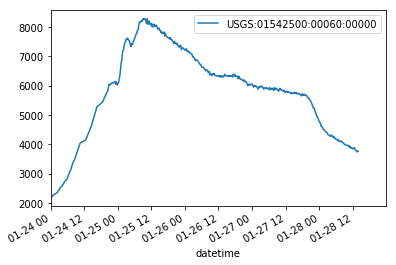

In [20]:
mult.plot()

In [21]:
start = mult.index.min()
stop = mult.index.max()
(stop-start)/pd.Timedelta('15 minutes')

479.0

In [22]:
# The length is the same as calculated above. No missing index values.
mult.shape

(438, 2)

In [23]:
# Missing index values from Jan. 24th were filled in
mult['2019-01-24']

,USGS:01542500:00060:00000_qualifiers,USGS:01542500:00060:00000
datetime,,
2019-01-24 00:00:00-05:00,P,2230.0
2019-01-24 00:15:00-05:00,P,2210.0
2019-01-24 00:30:00-05:00,P,2220.0
2019-01-24 00:45:00-05:00,P,2250.0
2019-01-24 01:00:00-05:00,P,2280.0
2019-01-24 01:15:00-05:00,P,2290.0
2019-01-24 01:30:00-05:00,P,2300.0
2019-01-24 01:45:00-05:00,P,2320.0
2019-01-24 02:00:00-05:00,P,2330.0


## Check that data requests with different frequencies of observations raise a warning.
the diff_freq request also has some other strange things about it that require special handling. For example, it reports a precipitation data series, but delivers the series with no data. Normally if you request a paramter with no data, it doesn't report a series.

In [24]:
diff = hf.extract_nwis_df(diff_freq)

In [25]:
diff

,USGS:01541000:00060:00000_qualifiers,USGS:01541000:00060:00000,USGS:01541000:00065:00000_qualifiers,USGS:01541000:00065:00000,USGS:01570500:00060:00000_qualifiers,USGS:01570500:00060:00000,USGS:01570500:00065:00000_qualifiers,USGS:01570500:00065:00000
datetime,,,,,,,,
2018-06-01 00:00:00-04:00,P,2540.0,P,8.25,A,42200.0,A,5.25
2018-06-01 00:15:00-04:00,P,2620.0,P,8.33,NaN,NaN,NaN,NaN
2018-06-01 00:30:00-04:00,P,2700.0,P,8.40,A,42200.0,A,5.25
2018-06-01 00:45:00-04:00,P,2780.0,P,8.47,NaN,NaN,NaN,NaN
2018-06-01 01:00:00-04:00,P,2860.0,P,8.54,A,41900.0,A,5.24
2018-06-01 01:15:00-04:00,P,2920.0,P,8.59,NaN,NaN,NaN,NaN
2018-06-01 01:30:00-04:00,P,2960.0,P,8.63,A,41900.0,A,5.24
2018-06-01 01:45:00-04:00,P,2960.0,P,8.63,NaN,NaN,NaN,NaN
2018-06-01 02:00:00-04:00,P,3020.0,P,8.68,A,41900.0,A,5.24


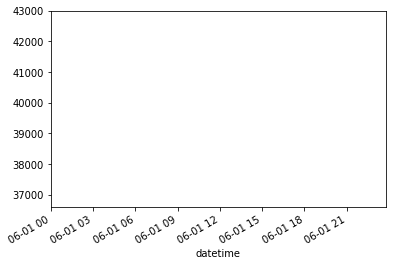

In [26]:
diff['USGS:01570500:00060:00000'].plot()